In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Verdana"
    }
</style>

##### ***Simple Neuron Model***
---
This file presents a simple neuron model based on two differential equations, involving four variables that govern the neuron's dynamic behavior and computational properties. The objective is to implement a function that simulates the time evolution of this system in response to external inputs, such as an injected DC current or a ramp input, to analyze the neuron's response under different stimulation conditions.

In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib as mpl # type: ignore
import matplotlib.pyplot as plt # type: ignore
from matplotlib import gridspec # type: ignore
import simulation_tools as simt # type: ignore

First, we define some functions that able us to create stimulation protocols. The building blocks of the protocols correspond to ramps, pulses, and zap current injections. Here are some examples of stimulations and current injection protocols:

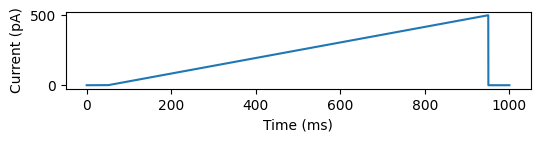

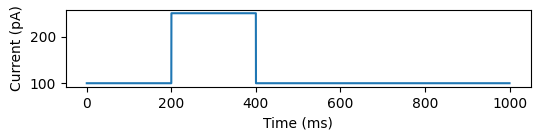

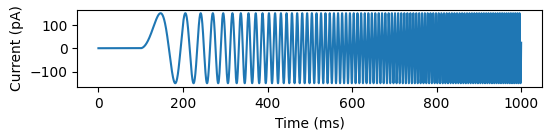

In [3]:
ramp, time_ramp = simt.generate_ramp_current(time_sim = 1000,
                                             start_time = 50,
                                             duration = 900,
                                             start_current = 0,
                                             end_current = 500)

square, time_square = simt.generate_square_pulse_current(time_sim = 1000, 
                                                         start_time = 200, 
                                                         duration = 200, 
                                                         start_current = 100, 
                                                         pulse_current = 250)

zap, time_zap = simt.generate_zap_current(time_sim = 1000,
                                          dc_current = 0, 
                                          start_time = 100, 
                                          duration = 900, 
                                          start_freq = 0.1, 
                                          end_freq = 200, 
                                          amplitude = 150)

currents = [ramp, square, zap]
times = [time_ramp, time_square, time_zap]

for current, time in zip(currents, times):
    simt.plot_current_protocol(current, time)

Using these functions + concatenating, we can build more complex stimulation protocols.

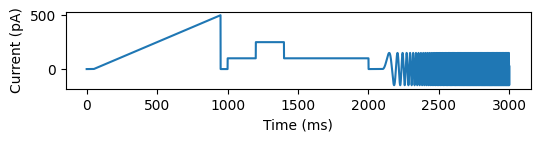

In [4]:
# Whole protocol
currents = [ramp, square, zap]
protocol, time_protocol = simt.concatenate_currents(currents = currents)
simt.plot_current_protocol(protocol, time_protocol)

There is also a function that generates a noisy current representing synaptic activity using the Ornstein-Uhlenbeck process.

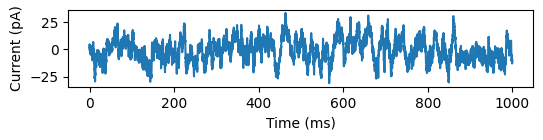

In [5]:
noise, noise_time = simt.generate_noisy_current(time_sim = 1000, amplitude = 10, tau = 5, rate_hz = 5, dt = 0.1)
simt.plot_current_protocol(noise, noise_time)

#### ***Simple Neuron Model***
---
The model is described by the following system of differential equations. If $ v \geq v_{peak} $, then $ v \leftarrow c $ and $ u \leftarrow u + d $:

$$
C v' = k(v - v_r)(v - v_t) - u + I 
$$

$$
u' = a \left[ \, b(v - v_r) - u \, \right]
$$

Where $ C $ represents the membrane capacitance, $ v $ is the membrane potential, $ u $ is the recovery current, $ v_r $ is the resting membrane potential, and $ v_t $ is the instantaneous threshold potential. The parameters $ k $ and $ b $ can be determined when the neuron's rheobase and input resistance are known. The sign of $ b $ determines whether the recovery current $ u $ is amplifying ($ b < 0 $) or resonant ($ b > 0 $). The parameter $ a $ corresponds to the recovery time constant. The spike cut-off value is $ v_{peak} $, and the voltage reset value is $ c $. The parameter $ d $ represents the total amount of outward minus inward currents activated during the spike, which influences the after-spike behavior. For more information see Chapter 8 of *Dynamical Systems in Neuroscience* by E. Izhikevich.


#### ***Simulation Example***
---

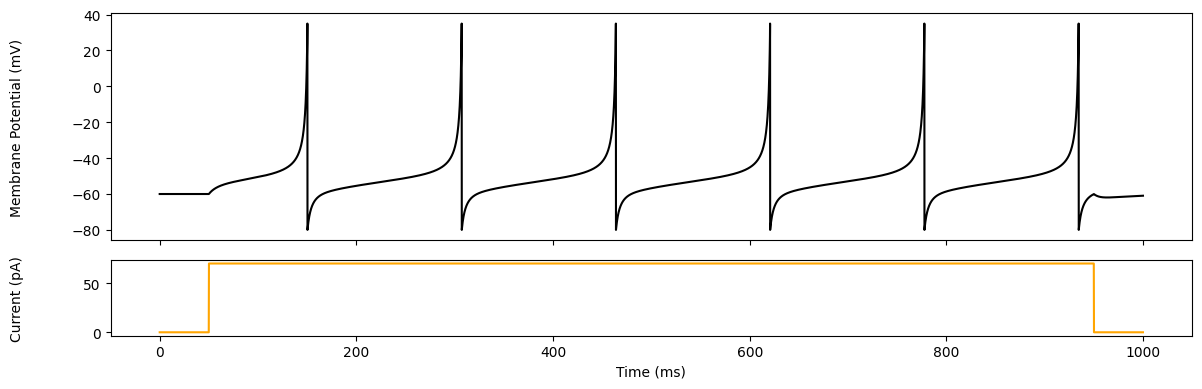

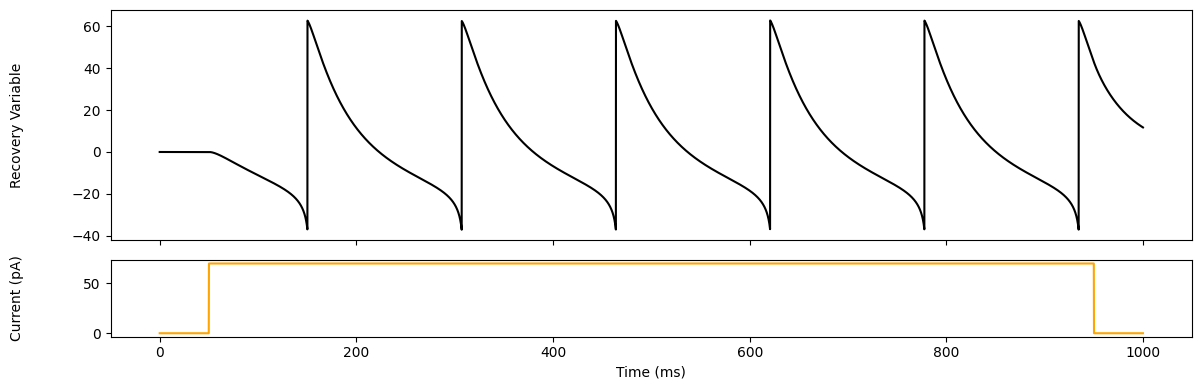

In [6]:
# Neuron parameters
params = {
        'C': 100, 'vr': -60, 'vt': -40, 'k': 0.7,
        'a': 0.03, 'b': -2, 'c': -80, 'd': 100,
        'vpeak': 35, 'T': 1000, 'dt': 0.1
        }

# Build the current injection protocol
pulse_current, pulse_time = simt.generate_square_pulse_current(time_sim = params['T'],
                                                               start_time = 50, 
                                                               duration = 900,
                                                               start_current = 0,
                                                               pulse_current = 70)

# Perform the simulation
time, voltage, recovery, spike_times = simt.izhikevich_neuron_sim(I_inj = pulse_current, **params)

simt.plot_simulation_voltage(time = time, voltage = voltage, protocol = pulse_current)
simt.plot_simulation_recovery(time = time, recovery = recovery, protocol = pulse_current)

#### ***Determining the F-I Curve of a Simple Neuron Model***
---

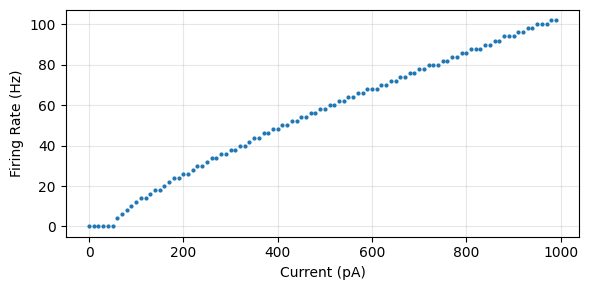

In [7]:
params = {
        'C': 100, 'vr': -60, 'vt': -40, 'k': 0.7,
        'a': 0.03, 'b': -2, 'c': -80, 'd': 100,
        'vpeak': 35, 'T': 500, 'dt': 0.1
        }

current_steps = np.arange(0, 1000, 10)
firing_rates = simt.simple_frequency_current_protocol(current_steps = current_steps, neuron_params = params, time_sim = params['T'])
simt.plot_fi_curve(current_steps = current_steps, firing_rates = firing_rates)

#### ***Phase Diagram***
---
By computing the derivatives of each variable in a wide range of values, we can plot the phase diagram of the simple model for a certain set of parameters. The flux of this diagram will give us information about the trajectories that the neuron will take for a given initial condition.

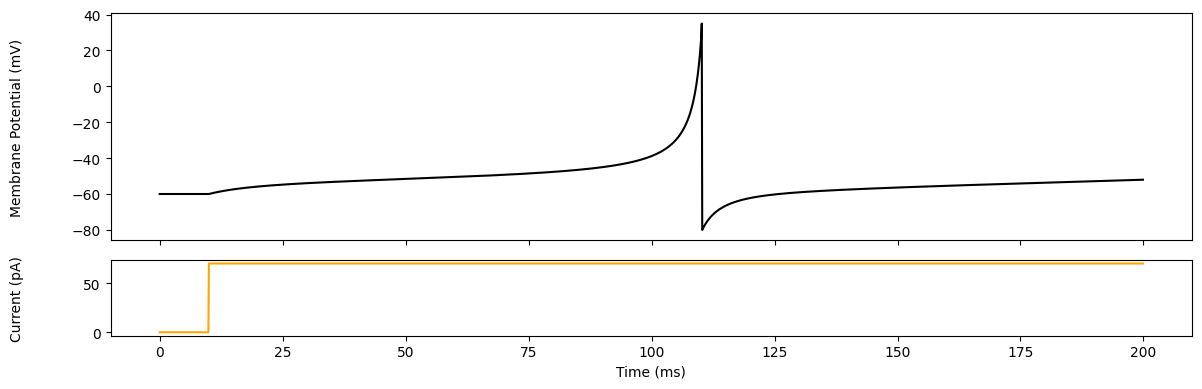

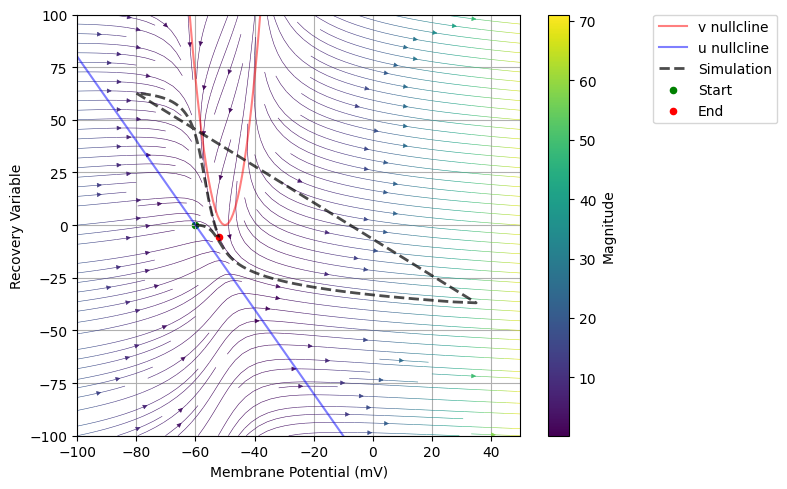

In [8]:
# Neuron parameters
params = {
        'C': 100, 'vr': -60, 'vt': -40, 'k': 0.7,
        'a': 0.03, 'b': -2, 'c': -80, 'd': 100,
        'vpeak': 35, 'T': 200, 'dt': 0.1
        }

# Build the current injection protocol
pulse_current, pulse_time = simt.generate_square_pulse_current(time_sim = params['T'],
                                                               start_time = 10, 
                                                               duration = 190,
                                                               start_current = 0,
                                                               pulse_current = 70)

# Perform the simulation
time, voltage, recovery, spike_times = simt.izhikevich_neuron_sim(I_inj = pulse_current, **params)

# Plot the simulation
simt.plot_simulation_voltage(time = time, voltage = voltage, protocol = pulse_current)

# Phase diagram params
params = {
        'C': 100, 'vr': -60, 'vt': -40, 'k': 0.7,
        'a': 0.03, 'b': -2, 'I': 70
        }

# Compute the phase diagram
simt.plot_phase_diagram(**params, v_trace = voltage, u_trace = recovery)

#### ***To do...***
---

- Two-compartment model (soma + active dendrite) simulation